<a id='home'></a>
### purpose

recreate the scatter plot between GF WZA full agains increment growth for the cross-variety model - original figure was in 11_validate_GF_offset_predictions.ipynb, but we want something prettier

### outline

[1. read in population data](#read)

[2. extract offset values from netCDF files](#netcdf)

[3. isolate pheno and offset vals](#iso)

[4. create scatter plot](#scatter)

In [1]:
from pythonimports import *
from myfigs import save_pdf

import xarray
import rioxarray

t1 = dt.now()  # notebook timer

savedir = '/data/projects/pool_seq/phenotypic_data/offset_misc_files/results/gradient_forests/figs'

lview,dview = get_client()

latest_commit()
session_info.show()

56 56
##################################################################
Today:	June 27, 2023 - 06:06:55
python version: 3.8.5
conda env: newpy385

Current commit of pythonimports:
commit 03d76f7a992130f4b94ac34a09ad439e918d3044  
Author: Brandon Lind <lind.brandon.m@gmail.com>  
Date:   Fri Jun 9 09:42:21 2023 -0400
##################################################################



<a id='read'></a>
# 1. read in population data
[top](#home)

### doug-fir pop data

In [2]:
envdata = {}

In [3]:
# map prov ID to our ID to translate pop names in phenotype data below
envdata['combined'] = pd.read_table('/data/projects/pool_seq/environemental_data/change_p6/df_ALL-naturalpops_raw_env-19variables_change-p6.txt')
envdata['combined'].index = envdata['combined']['our_id'].tolist()
provdict = dict(zip(envdata['combined']['prov'], envdata['combined']['our_id']))
print(provdict)

{1: 'DF_p1', 2: 'DF_p2', 3: 'DF_p3', 4: 'DF_p4', 5: 'DF_p5', 6: 'DF_p6', 7: 'DF_p7', 8: 'DF_p8', 9: 'DF_p9', 10: 'DF_p10', 11: 'DF_p11', 12: 'DF_p12', 13: 'DF_p13', 14: 'DF_p14', 15: 'DF_p15', 16: 'DF_p16', 17: 'DF_p17', 18: 'DF_p18', 19: 'DF_p19', 20: 'DF_p20', 23: 'DF_p23', 24: 'DF_p24', 25: 'DF_p25', 26: 'DF_p26', 27: 'DF_p27', 28: 'DF_p28', 29: 'DF_p29', 30: 'DF_p30', 31: 'DF_p31', 32: 'DF_p32', 33: 'DF_p33', 34: 'DF_p34', 35: 'DF_p35', 36: 'DF_p36', 37: 'DF_p37', 38: 'DF_p38', 39: 'DF_p39', 40: 'DF_p40', 41: 'DF_p41', 42: 'DF_p42', 43: 'DF_p43', 44: 'DF_p44', 45: 'DF_p45', 46: 'DF_p46', 47: 'DF_p47', 48: 'DF_p48', 49: 'DF_p49', 50: 'DF_p50', 51: 'DF_p51', 52: 'DF_p52', 53: 'DF_p53', 54: 'DF_p54', 55: 'DF_p55', 56: 'DF_p56', 57: 'DF_p57', 58: 'DF_p58', 59: 'DF_p59', 60: 'DF_p60', 61: 'DF_p61', 62: 'DF_p62', 72: 'DF_p72', 73: 'DF_p73', 74: 'DF_p74', 75: 'DF_p75', 76: 'DF_p76', 77: 'DF_p77', 78: 'DF_p78', 79: 'DF_p79', 80: 'DF_p80', 81: 'DF_p81', 82: 'DF_p82', 83: 'DF_p83', 84: 'DF_p

In [4]:
# create color dict for pop colors

df_colors = pd.read_table('/data/projects/pool_seq/environemental_data/change_p6/doug-fir_colored_pops.txt')
df_colors.loc[df_colors['our_id']=='DF_p40', ['group', 'group_color']] = 'North BC', '#f205f4'  # as in ../01_split_training_and_testing.ipynb

cdict = dict(
    zip(df_colors['our_id'],
        df_colors['group_color'])
)


assert len(cdict) == nrow(envdata['combined'])

### doug-fir phenotypes

In [5]:
# get common garden files for doug-fir
# read in two phenofiles, combine - skip this after updating phenotypes in Nov 2021

# drought = pd.read_table('/data/projects/pool_seq/phenotypic_data/doug-fir/Data_Drought_Blups_May_01_2021_Brandon_prov.txt')
# drought = drought[drought['Prov'].isin(keys(provdict))]
# drought.index = drought['Prov'].map(provdict)
# print(sum(envdata['combined'].index.isin(drought.index)))

# _phenodata = pd.read_table('/data/projects/pool_seq/phenotypic_data/doug-fir/Data_Totem_Blups_April_26_2021_Brandon-BLUPs_prov.txt')
_phenodata = pd.read_excel('/data/projects/pool_seq/phenotypic_data/doug-fir/Data_Totem_Blups_Nov_17_2021_Brandon.xlsx')  # new pheno
_phenodata = _phenodata[_phenodata['Prov'].isin(keys(provdict))]
assert nrow(_phenodata) == nrow(envdata['combined'])
_phenodata.index = _phenodata['Prov'].map(provdict)
_phenodata.index.name = None
print(sum(envdata['combined'].index.isin(_phenodata.index)))
# _phenodata = _phenodata.loc[envdata.index]

# blups = _phenodata[['blup_increment', 'blup_shoot_biomass']].copy()
dfdata = _phenodata[['blup_increment', 'blup_shoot_biomass']].copy()
# dfdata = pd.merge(blups,
#                   drought[['Blup_lm_slope_corrected',
#                            'Blup_beta_inflec_correc_before',
#                            ' Blup_Tem4_corrected_fv_fm',
#                            ' Blup_Tem3_corrected_fv_fm',
#                            'Blup_h_max_dry',
#                            'Blup_h_increment_total_wet']],
#                   left_index=True,
#                   right_index=True)

dfdata.head()

73


,blup_increment,blup_shoot_biomass
DF_p1,35.15544,15.445821
DF_p2,28.85236,12.384858
DF_p3,16.22677,3.514184
DF_p4,18.40748,4.782511
DF_p5,14.47699,2.578436


In [6]:
phenodata = {
    'combined' : {'vancouver' : dfdata}
}

<a id='netcdf'></a>
# 2. extract offset values from netCDF files
[top](#home)

In [7]:
def read_offset_file(offset_file, x_dim="latitude", y_dim="longitude"):
    """Read in netcdf file."""
    import xarray as xr
    import rioxarray

    ds = xr.open_dataset(offset_file)
    ds.rio.set_spatial_dims(x_dim=x_dim, y_dim=y_dim, inplace=True)
    ds.rio.write_crs("epsg:4326", inplace=True)
    
    layers = [var for var in list(ds.variables) if var not in ['crs', 'longitude', 'latitude']]
    assert len(layers) == 1
    layer = layers[0]
    vals = ds[layer][:,:]
    lons = ds[layer]['longitude']
    lats = ds[layer]['latitude']
    
    return ds, layer, vals, lons, lats
dview['read_offset_file'] = read_offset_file


def get_offset_data(offset_file, envdata, latcol='LAT', loncol='LONG'):
    """Read in offset data from netCDF `offset_file` for each of the pops in `envdata`."""
    import xarray as xr

    # read in offset data
    ds,layer,*args = read_offset_file(offset_file)

    # pull offset values directly from the shapefile
    target_lat = xr.DataArray(envdata[latcol], dims='points')
    target_lon = xr.DataArray(envdata[loncol], dims='points')
    offsets = ds[layer].sel(longitude=target_lon, latitude=target_lat, method='nearest').to_dataframe()
    offsets.index = envdata['our_id'].tolist()
    
    try:
        assert offsets[offsets.columns[-1]].isnull().sum() == 0
    except AssertionError as e:
        # there can be null vals if a population resides outside of the shapefile boundaries ...
        # ... when shapefiles have been used to clip climate data
        print(offset_file, envdata.index)
        raise e

    return offsets


In [8]:
# get the files that contain the offset information
fitting_dir = '/data/projects/pool_seq/phenotypic_data/offset_misc_files/fitting'
ncfiles = fs(fitting_dir, pattern='combined-wza-real-full', endswith='.nc', exclude=['NA_'])
assert len(ncfiles) == 1

ncfiles[0]

'/data/projects/pool_seq/phenotypic_data/offset_misc_files/fitting/combined-wza-real-full_gradient_forest_training_combined-vancouver_all-envs_WGS84_clipped_offset.nc'

In [9]:
# for each of the netCDF files, partition into garden, species, dataset (wza/baypass/random), and whether ...
# ... it's one of the k-fold cross-validation sets or the full (no test set) dataset
# raw_offset[garden][spp][dataset][k_or_full] = f
raw_offset = wrap_defaultdict(None, 4)
species = []
for f in ncfiles:
    spp,method,setname,kfold,*args = op.basename(f).rstrip(".txt").split("-")
    kfold = kfold.split("_gradient")[0]
    garden = args[0].split("_")[0]
    dataset = '-'.join([method, setname])
    
    assert garden in ['vancouver', 'christine', 'fontbrune']
    assert spp in ['wl', 'jp', 'fdi', 'fdc', 'combined']
    assert kfold in ['full', 'k1', 'k2', 'k3', 'k4']
    
    species.append(spp)
    raw_offset[garden][spp][dataset][kfold] = f

for garden,sppdict in raw_offset.items():
    for spp,datadict in sppdict.items():
        for dataset,kdict in datadict.items():
            print(garden, spp, dataset, len(kdict), keys(kdict))

vancouver combined wza-real 1 ['full']


In [10]:
# retrieve offset data in parallel
jobs = []
arg_order = []
for garden,sppdict in raw_offset.items():
    for spp,datadict in sppdict.items():
        latcol = 'LAT' #if spp != 'wl' else 'Latitude'
        loncol = 'LONG' #if spp != 'wl' else 'Longitude'
        for dataset,kdict in datadict.items():
            for kfold,f in kdict.items():
                arg_order.append([garden, spp, dataset, kfold, f])
                jobs.append(
                    lview.apply_async(
                        get_offset_data, *(f, envdata[spp]), **dict(latcol=latcol, loncol=loncol)
                    )
                )
watch_async(jobs)


Watching 1 jobs ...


100%|███████████████| 1/1 [00:00<00:00, 9554.22it/s]


In [11]:
# get job returns, store in dict
offsets = wrap_defaultdict(None, 4)
for i,job in enumerate(jobs):
    garden,spp,dataset,kfold,f = arg_order[i]
    df = job.r
    offsets[garden][spp][dataset][kfold] = df.copy()
    
df.head()

,crs,longitude,latitude,X..Downloads.NA_ENSEMBLE_rcp45_2050s.TD_WGS84_clipped_df_combined.tif
DF_p1,0,-126.639401,49.787773,0.024996
DF_p2,0,-122.735252,50.325470,0.088759
DF_p3,0,-115.628298,50.535873,0.113735
DF_p4,0,-122.337824,52.032074,0.112037
DF_p5,0,-119.041506,49.016294,0.105254


<a id='iso'></a>
# 3. isolate pheno and offset vals

[top](#home)

In [12]:
offsetdf = offsets['vancouver']['combined']['wza-real']['full']
offset = offsetdf[offsetdf.columns[-1]]

offset

DF_p1     0.024996
DF_p2     0.088759
DF_p3     0.113735
DF_p4     0.112037
DF_p5     0.105254
            ...   
DF_p80    0.013900
DF_p81    0.019737
DF_p82    0.021846
DF_p83    0.016875
DF_p84    0.019232
Name: X..Downloads.NA_ENSEMBLE_rcp45_2050s.TD_WGS84_clipped_df_combined.tif, Length: 73, dtype: float32

In [13]:
phenovals = phenodata['combined']['vancouver']['blup_increment']

phenovals

DF_p1     35.15544
DF_p2     28.85236
DF_p3     16.22677
DF_p4     18.40748
DF_p5     14.47699
            ...   
DF_p80    34.35363
DF_p81    36.69975
DF_p82    34.51143
DF_p83    36.22062
DF_p84    38.56369
Name: blup_increment, Length: 73, dtype: float64

<a id='scatter'></a>
# 4. create scatter plot

[top](#home)

In [14]:
varcolors = {'FDC' : 'limegreen', 'FDI' : 'purple'}
varmap = dict(zip(envdata['combined']['our_id'], envdata['combined']['Variety']))

Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/results/gradient_forests/figs/combined_vancouver_wza-real_full_maintext_blup_increment.pdf


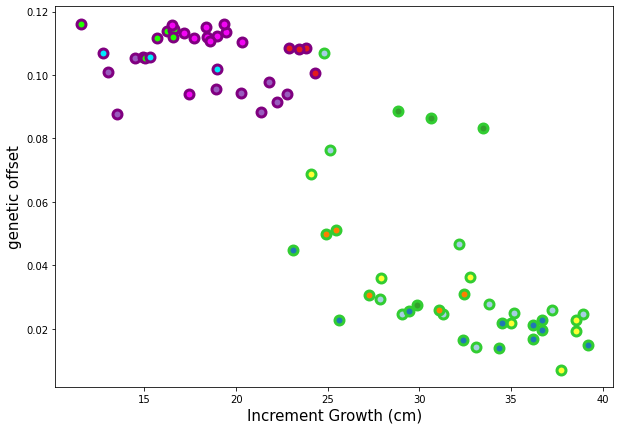

In [15]:
fig, ax = plt.subplots(figsize=(10, 7))

for pop in offset.index:
    variety = varmap[pop]
    varcolor = varcolors[variety]
    ax.scatter(phenovals.loc[pop], offset.loc[pop], marker='o', edgecolor=varcolor, facecolor=cdict[pop],
              linewidth=3, s=80)

ax.set_xlabel('Increment Growth (cm)', fontsize=15)
ax.set_ylabel('genetic offset', fontsize=15)

# gradient_image(ax=ax, cmap=cmap, transform=ax.transAxes, extent=(0,1,0,1), cmap_range=(0.0, 0.5))

saveloc = op.join(savedir, 'combined_vancouver_wza-real_full_maintext_blup_increment.pdf')
save_pdf(saveloc)

In [16]:
formatclock(dt.now() - t1, exact=True)

'0-00:00:03'

[top](#home)